# Transform

Features names:
* cpi_energy -> cpi_energy
* gasoline_price -> gasoline_price_per_gallon
* imports_and_exports -> Undefined
* input_utilization -> Needs aggregation
* oil_production -> Needs filtering and aggregation
* us_dollar_index -> us_dollar_index
* volatility_index -> volatility_index
* wti_prices -> price_per_barrel
* Stock Price -> Undefined

In [1]:
import os
os.chdir('..')

In [2]:
%pwd

'c:\\Users\\User\\Desktop\\DS\\Projects\\oil-optimization'

In [3]:
import pandas as pd
from datetime import date
from oil_optimization.utils.io_helpers import read_yaml
from datetime import timedelta

def setup():
    config = read_yaml('config/config.yml')
    data_dir = config['data_ingestion']['root_dir']
    raw_data_dir = data_dir + '/raw'
    file_list = os.listdir(raw_data_dir)

    dataframes = {}
    for filename in file_list:
        key = filename[:-4] #Removing .csv extension from filename
        try:
            dataframes[key] = pd.read_csv(f'{raw_data_dir}/{filename}', parse_dates=['date'])
        except:
            dataframes[key] = pd.read_csv(f'{raw_data_dir}/{filename}', parse_dates=['period'])
    
    return dataframes

In [4]:
df_dict = setup()

features_df = pd.DataFrame()
today = date.today().strftime('%Y-%m-%d')
#Define base DataFrame
features_df['period'] =  pd.date_range(start='2015-01-02',
                                       end=today,freq='W') - timedelta(days=2)
#Setting key to merge with monthly data
features_df['year_month'] = features_df['period'].dt.strftime('%Y-%m')

### cpi_energy

In [ ]:
df_cpi = df_dict['cpi_energy']
#Filtering relevant data
df_cpi_filter = df_cpi.iloc[:,2:].rename({'value':'cpi_energy'},axis=1)

In [ ]:
df_cpi_filter['year_month'] = df_cpi_filter['date'].dt.strftime('%Y-%m')

In [ ]:
merge_periods = features_df.groupby('year_month').first().reset_index()
merge_cpi = merge_periods.merge(df_cpi_filter, on='year_month',how='left')

In [ ]:
dF_cpi_final = merge_cpi.merge(features_df,on='period')[['period','cpi_energy']]

In [ ]:
features_df = features_df.merge(dF_cpi_final,on='period',how='left')

In [ ]:
features_df

,period,year_month,cpi_energy
0,2015-01-02,2015-01,199.926
1,2015-01-09,2015-01,NaN
2,2015-01-16,2015-01,NaN
3,2015-01-23,2015-01,NaN
4,2015-01-30,2015-01,NaN
...,...,...,...
560,2025-09-26,2025-09,NaN
561,2025-10-03,2025-10,NaN
562,2025-10-10,2025-10,NaN
563,2025-10-17,2025-10,NaN


### gasoline_price

<Axes: >

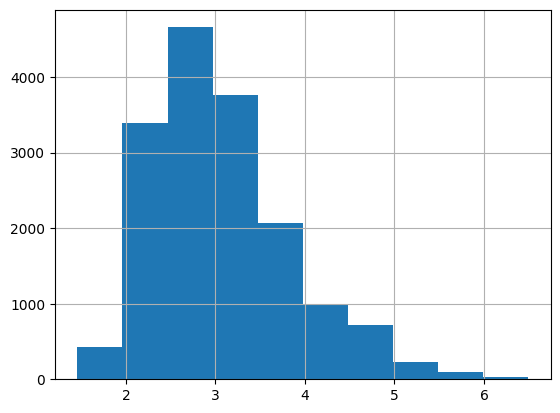

In [ ]:
df_dict['gasoline_price']['value'].hist()

In [ ]:
df_dict['gasoline_price']['value'].skew()

np.float64(0.9614046289893812)

In [ ]:
counts = pd.cut(df_dict['gasoline_price']['value'],bins=10).value_counts(normalize=True).sort_index().to_frame()
counts['cumsum'] = counts['proportion'].cumsum()
counts.round(2)

,proportion,cumsum
value,,
"(1.452, 1.961]",0.03,0.03
"(1.961, 2.465]",0.21,0.23
"(2.465, 2.968]",0.28,0.52
"(2.968, 3.472]",0.23,0.75
"(3.472, 3.976]",0.13,0.87
"(3.976, 4.48]",0.06,0.93
"(4.48, 4.984]",0.04,0.98
"(4.984, 5.487]",0.01,0.99
"(5.487, 5.991]",0.01,1.00


In [ ]:
df_dict['gasoline_price'].groupby('area-name')['value'].skew()

area-name
BOSTON                      0.836710
CALIFORNIA                  0.525378
CHICAGO                     0.760264
CLEVELAND                   0.646316
COLORADO                    0.663873
DENVER                      0.666483
FLORIDA                     0.736960
HOUSTON                     0.866693
LOS ANGELES                 0.575509
MASSACHUSETTS               0.827184
MIAMI                       0.788394
MINNESOTA                   0.647136
NEW YORK                    0.836262
NEW YORK CITY               0.791803
OHIO                        0.628195
PADD 1                      0.741191
PADD 1A                     0.834042
PADD 1B                     0.754137
PADD 1C                     0.702538
PADD 2                      0.682960
PADD 3                      0.799323
PADD 4                      0.648976
PADD 5                      0.550293
PADD 5 EXCEPT CALIFORNIA    0.569162
SAN FRANCISCO               0.495932
SEATTLE                     0.382715
TEXAS                       

In [24]:
df_gasoline = df_dict['gasoline_price']
df_gasoline_agg = df_gasoline.groupby('period')['value'].mean().reset_index()

In [25]:
import datetime
df_gasoline_agg['period'] = df_gasoline_agg['period'] - datetime.timedelta(3)


In [28]:
features_df.merge(df_gasoline_agg, on='period',how='left')

,period,year_month,value
0,2015-01-02,2015-01,2.385552
1,2015-01-09,2015-01,2.300862
2,2015-01-16,2015-01,2.221552
3,2015-01-23,2015-01,2.181103
4,2015-01-30,2015-01,2.194793
...,...,...,...
560,2025-09-26,2025-09,3.429483
561,2025-10-03,2025-10,3.421241
562,2025-10-10,2025-10,3.363000
563,2025-10-17,2025-10,3.338172


### imports_and_exports

In [37]:
df_imp_exp = df_dict['imports_and_exports']
cols = ['period','process-name','value']
df_imp_exp = df_imp_exp[cols]
df_imp_exp = df_imp_exp[df_imp_exp['process-name'].isin(['Imports','Exports'])]

In [46]:
df_imp_exp = df_imp_exp.pivot(columns=['process-name'],values='value',index='period')

In [48]:
features_df.merge(df_imp_exp,on='period',how='left')

,period,year_month,Exports,Imports
0,2015-01-02,2015-01,388.0,6856.0
1,2015-01-09,2015-01,388.0,7492.0
2,2015-01-16,2015-01,388.0,7218.0
3,2015-01-23,2015-01,502.0,7422.0
4,2015-01-30,2015-01,502.0,7387.0
...,...,...,...,...
560,2025-09-26,2025-09,3751.0,5833.0
561,2025-10-03,2025-10,3590.0,6403.0
562,2025-10-10,2025-10,4466.0,5525.0
563,2025-10-17,2025-10,4203.0,5918.0


### input_utilization

In [58]:
df_input = df_dict['input_utilization']
df_input

,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2015-01-02,R20,PADD 2,EPC0,Crude Oil,YIY,Refinery Net Input,WCRRIP22,Midwest (PADD 2) Refiner Net Input of Crude Oi...,3600,MBBL/D
1,2015-01-02,R40,PADD 4,EPC0,Crude Oil,YIY,Refinery Net Input,WCRRIP42,Rocky Mountain (PADD 4) Refiner Net Input of C...,579,MBBL/D
2,2015-01-02,R50,PADD 5,EPC0,Crude Oil,YIY,Refinery Net Input,WCRRIP52,West Coast (PADD 5) Refiner Net Input of Crude...,2439,MBBL/D
3,2015-01-02,R10,PADD 1,EPC0,Crude Oil,YIY,Refinery Net Input,WCRRIP12,East Coast (PADD 1) Refiner Net Input of Crude...,1158,MBBL/D
4,2015-01-02,R30,PADD 3,EPC0,Crude Oil,YIY,Refinery Net Input,WCRRIP32,Gulf Coast (PADD 3) Refiner Net Input of Crude...,8643,MBBL/D
...,...,...,...,...,...,...,...,...,...,...,...
2815,2025-10-17,R30,PADD 3,EPC0,Crude Oil,YIY,Refinery Net Input,WCRRIP32,Gulf Coast (PADD 3) Refiner Net Input of Crude...,8781,MBBL/D
2816,2025-10-17,R50,PADD 5,EPC0,Crude Oil,YIY,Refinery Net Input,WCRRIP52,West Coast (PADD 5) Refiner Net Input of Crude...,1870,MBBL/D
2817,2025-10-17,R10,PADD 1,EPC0,Crude Oil,YIY,Refinery Net Input,WCRRIP12,East Coast (PADD 1) Refiner Net Input of Crude...,847,MBBL/D
2818,2025-10-17,R40,PADD 4,EPC0,Crude Oil,YIY,Refinery Net Input,WCRRIP42,Rocky Mountain (PADD 4) Refiner Net Input of C...,599,MBBL/D


In [87]:
df_input_sorted['series-description'].unique()

array(['East Coast (PADD 1) Refiner Net Input of Crude Oil (Thousand Barrels per Day)',
       'Midwest (PADD 2) Refiner Net Input of Crude Oil (Thousand Barrels per Day)',
       'Gulf Coast (PADD 3) Refiner Net Input of Crude Oil (Thousand Barrels per Day)',
       'Rocky Mountain (PADD 4) Refiner Net Input of Crude Oil (Thousand Barrels per Day)',
       'West Coast (PADD 5) Refiner Net Input of Crude Oil (Thousand Barrels per Day)'],
      dtype=object)

In [91]:
df_input_sorted = df_input.sort_values(by=['period','area-name'])
df_input_refinery = df_input_sorted.pivot(index='period',columns='area-name',values='value')
df_input_refinery.columns = ['East Coast (PADD 1)',
                             'Midwest (PADD 2)',
                             'Gulf Coast (PADD 3)',
                             'Rocky Mountain (PADD 4)',
                             'West Coast (PADD 5)']

In [94]:
features_df.merge(df_input_refinery,right_index=True, left_on='period',how='left')

,period,year_month,East Coast (PADD 1),Midwest (PADD 2),Gulf Coast (PADD 3),Rocky Mountain (PADD 4),West Coast (PADD 5)
0,2015-01-02,2015-01,1158.0,3600.0,8643.0,579.0,2439.0
1,2015-01-09,2015-01,1118.0,3517.0,8272.0,599.0,2388.0
2,2015-01-16,2015-01,996.0,3179.0,7844.0,577.0,2312.0
3,2015-01-23,2015-01,1104.0,3348.0,7857.0,581.0,2366.0
4,2015-01-30,2015-01,1129.0,3618.0,7845.0,591.0,2361.0
...,...,...,...,...,...,...,...
560,2025-09-26,2025-09,744.0,4029.0,8616.0,638.0,2140.0
561,2025-10-03,2025-10,824.0,3982.0,8823.0,619.0,2048.0
562,2025-10-10,2025-10,828.0,3589.0,8271.0,575.0,1866.0
563,2025-10-17,2025-10,847.0,3635.0,8781.0,599.0,1870.0


### oil_production

In [97]:
df_prod = df_dict['oil_production']
df_prod

,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2015-01-01,SKS,USA-KS,EPC0,Crude Oil,FPF,Field Production,MCRFPKS2,Kansas Field Production of Crude Oil (Thousand...,134,MBBL/D
1,2015-01-01,SSD,USA-SD,EPC0,Crude Oil,FPF,Field Production,MCRFPSD1,South Dakota Field Production of Crude Oil (Th...,158,MBBL
2,2015-01-01,SIL,USA-IL,EPC0,Crude Oil,FPF,Field Production,MCRFPIL1,Illinois Field Production of Crude Oil (Thousa...,794,MBBL
3,2015-01-01,SCA,CALIFORNIA,EPC0,Crude Oil,FPF,Field Production,MCRFPCA2,California Field Production of Crude Oil (Thou...,564,MBBL/D
4,2015-01-01,SNY,NEW YORK,EPC0,Crude Oil,FPF,Field Production,MCRFPNY2,New York Field Production of Crude Oil (Thousa...,1,MBBL/D
...,...,...,...,...,...,...,...,...,...,...,...
10155,2025-07-01,SIL,USA-IL,EPC0,Crude Oil,FPF,Field Production,MCRFPIL2,Illinois Field Production of Crude Oil (Thousa...,18,MBBL/D
10156,2025-07-01,R10,PADD 1,EPC0,Crude Oil,FPF,Field Production,MCRFPP12,East Coast (PADD 1) Field Production of Crude ...,53,MBBL/D
10157,2025-07-01,R50,PADD 5,EPC0,Crude Oil,FPF,Field Production,MCRFPP52,West Coast (PADD 5) Field Production of Crude ...,624,MBBL/D
10158,2025-07-01,SMO,USA-MO,EPC0,Crude Oil,FPF,Field Production,MCRFPMO2,Missouri Field Production of Crude Oil (Thousa...,0,MBBL/D


In [110]:
df_prod_filter = df_prod[df_prod['units'] == 'MBBL']
df_prod_sum = df_prod_filter.groupby('period')['value'].sum().reset_index()

In [ ]:
df_prod_sum['year_month'] = df_prod_sum['period'].dt.strftime('%Y-%m')
df_prod_sum

,period,value,year_month
0,2015-01-01,581987,2015-01
1,2015-02-01,531674,2015-02
2,2015-03-01,594531,2015-03
3,2015-04-01,579731,2015-04
4,2015-05-01,587477,2015-05
...,...,...,...
122,2025-03-01,834319,2025-03
123,2025-04-01,808165,2025-04
124,2025-05-01,833923,2025-05
125,2025-06-01,812211,2025-06
